In [1]:
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from utils import *

In [2]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
env_id = "gym_examples/GridWorld-v1"
gridworld_size = 3
max_steps = 20
gamma = 0.95

num_trials = 1000
num_episodes_train = 5000
num_episodes_eval = 100

lr_sched_type = "linear"
lr_sched_fn = create_lr_sched_fn(lr_sched_type)

max_eps = 1.0
min_eps = 0.05
decay_rate = 0.0005
eps_sched_type = "poly"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

haver_const = 40.0
est_name = "haver" 
q_algo_name = "haver_q_learning"
q_algo = create_q_algo(q_algo_name)

# create gym env
env = gym.make(env_id, size=gridworld_size)
env_wrapped = FlattenObservation(env)
num_actions = env_wrapped.action_space.n
# print(f"num_actions = {num_actions}")
# print(env_wrapped.reset())
# stop

manager = multiprocessing.Manager()
episode_lengths_list = manager.list()
episode_rewards_list = manager.list()
episode_start_vals_list = manager.list()

def run_trial(i_trial, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    env = gym.make(env_id, size=gridworld_size)
    env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)

    lr_sched_fn = create_lr_sched_fn(lr_sched_type)
    eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(q_algo_name)

    # init Q_table, Q_nvisits
    Q_table = defaultdict(lambda: np.zeros(num_actions))
    Q_nvisits = defaultdict(lambda: np.zeros(num_actions))
    Q_table, stats = q_algo(
        env_wrapped, Q_table, Q_nvisits, num_episodes_train, max_steps,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)

    episode_lengths, episode_rewards, episode_start_vals= zip(*stats)
    episode_lengths_list.append(episode_lengths)
    episode_rewards_list.append(episode_rewards)
    episode_start_vals_list.append(episode_start_vals)

args = dict()
haver_const_ary = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
haver_const_ary = [20.0]
pool = multiprocessing.Pool()
for haver_const in haver_const_ary:
    start_time = time.time()
    print(f"\n-> haver_const = {haver_const}")
    args["haver_const"] =  haver_const
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_lengths_ary = np.hstack([episode_lengths_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_start_vals_ary = np.hstack([episode_start_vals_list])

    episode_lengths_mean = np.mean(episode_lengths_ary, 0)
    episode_rewards_mean = np.mean(episode_rewards_ary, 0)
    episode_start_vals_mean = np.mean(episode_start_vals_ary, 0)
    print(f"last_episode_length = {episode_lengths_mean[-1]}")
    print(f"last_episode_reward_per_step = {episode_rewards_mean[-1]:.4f}")
    print(f"last_episode_estim_start_val = {episode_start_vals_mean[-1]:.4f}")
    
    episode_lengths_list[:] = []
    episode_rewards_list[:] = []
    episode_start_vals_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time}")


-> haver_const = 20.0
last_episode_length = 5.443
last_episode_reward_per_step = 0.4367
last_episode_estim_start_val = -2.4821
it takes 578.769847869873


Process ForkPoolWorker-6:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
Process ForkPoolWorker-13:
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tnn/m

In [3]:
# for i_trial in range(num_trials):
#     last_episode_length = episode_lengths_list[i_trial,-1]
#     if episode_lengths_list[i_trial,-1] > 4:
#         print(i_trial, last_episode_length)
print(episode_lengths_ary[:100,-1])

[ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  4  4  4  4 20 20  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4 20  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  4  4  4  4  4  4  4  4  4  4 20  5  4  4 20  4  4  4  4  4  4  4
  4  4  4  4]


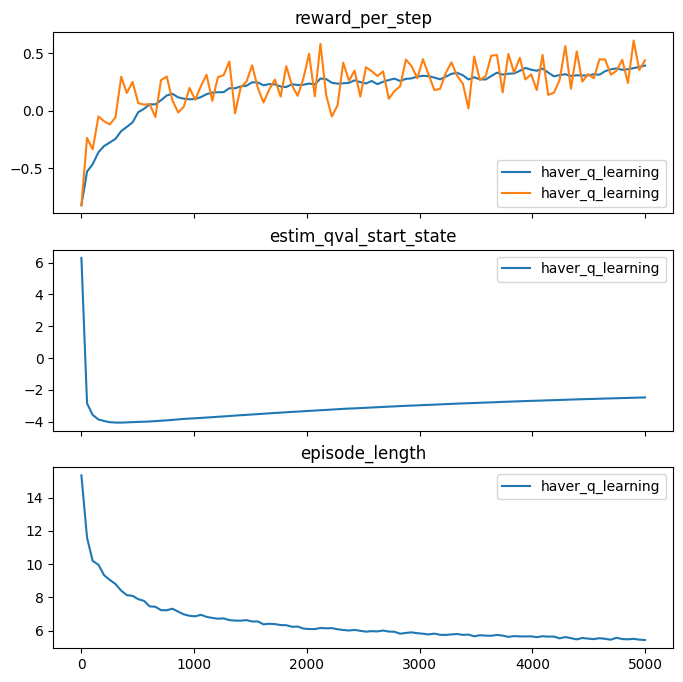

In [4]:

fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

x_ary = np.linspace(0, num_episodes_train-1, num=100, dtype=np.int32)
axes[0].plot(x_ary, running_avg(episode_rewards_mean[x_ary], 10), label=q_algo_name)
axes[0].set_title("reward_per_step")
axes[0].plot(x_ary, episode_rewards_mean[x_ary], label=q_algo_name)
axes[0].set_title("reward_per_step")
axes[0].legend()
axes[1].plot(x_ary, episode_start_vals_mean[x_ary], label=q_algo_name)
axes[1].set_title("estim_qval_start_state")
axes[1].legend()
axes[2].plot(x_ary, episode_lengths_mean[x_ary], label=q_algo_name)
axes[2].set_title("episode_length")
axes[2].legend()
plt.show()